In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
def calculate_propensity(y, reactant_matrix, microscopic_rate_constants,
                        previous_propensities = None, is_propensity_update_needed = None):
    """
    Calculate propensities for Gillespie algorithm.

    Args:
        y (numpy.ndarray): Current state of the system (species counts).
        reactant_matrix (numpy.ndarray): Matrix representing reactants in each reaction.
        microscopic_rate_constants (numpy.ndarray): Rate constants for each reaction.

    Returns:
        numpy.ndarray: Array of propensities for each reaction.

    Example:
        Suppose you have the following input matrices and arrays:

        y = np.array([10, 5, 3])  # Current state (species counts)
        
        reactant_matrix = np.array([[2, 1, 0],  # Example reactant matrix
                                    [0, 1, 1]])

        microscopic_rate_constants = np.array([0.1, 0.05])  # Example rate constants

        propensities = calculate_propensity(y, reactant_matrix, microscopic_rate_constants)
        print(propensities)
        # Output: [0.1 * comb(10, 2) * comb(5, 1), 0.05 * comb(5, 1) * comb(3, 1)]

    Note:
        The function calculates the propensity of each reaction in a Gillespie algorithm.
        Propensity is the product of the microscopic rate constant and combinatorial terms
        based on the reactant matrix and current state (y) of the system.
    """
    
    if previous_propensities is None: # simple case
        
        propensities = np.zeros(len(reactant_matrix))

        # Loop over each reaction
        for reaction_index, reaction in enumerate(reactant_matrix):
            propensity = microscopic_rate_constants[reaction_index]

            # Multiply by the combinatorial term for each reactant
            for species_index, species_count in enumerate(reaction):
                propensity *= math.comb(y[species_index], species_count)

            propensities[reaction_index] = propensity
        
        return propensities

    else: # optimization case
        # Loop over each reaction
        for reaction_index, reaction in enumerate(reactant_matrix):
            if is_propensity_update_needed[reaction_index] != 0:
                # Update propensity if entry is not zero
                propensity = microscopic_rate_constants[reaction_index]

                # Multiply by the combinatorial term for each reactant
                for species_index, species_count in enumerate(reaction):
                    propensity *= math.comb(y[species_index], species_count)
                
                previous_propensities[reaction_index] = propensity
            
        return previous_propensities

In [3]:
def gillespie_simulation(max_time, y_init,
                         reactant_matrix, product_matrix, microscopic_rate_constants,
                         full_update_scheme = False):
    """
    Perform Gillespie simulation for a chemical reaction system.

    Args:
        max_time (float): Maximum simulation time.
        y_init (numpy.ndarray): Initial state of the system (species counts).
        reactant_matrix (numpy.ndarray): Matrix representing reactants in each reaction.
        product_matrix (numpy.ndarray): Matrix representing products in each reaction.
        microscopic_rate_constants (numpy.ndarray): Rate constants for each reaction.
        full_update_scheme (bool): controls if update every propensity entry in each iteration.

    Returns:
        tuple: A tuple containing arrays for recorded time points (t_record) and
               corresponding system states (y_record).

    Example:
        Suppose you have the following input matrices and arrays:

        max_time = 100.0
        y_init = np.array([10, 5, 3])  # Initial state (species counts)
        
        reactant_matrix = np.array([[2, 1, 0],  # Example reactant matrix
                                    [0, 1, 1]])

        product_matrix = np.array([[0, 1, 0],  # Example product matrix
                                   [1, 0, 1]])

        microscopic_rate_constants = np.array([0.1, 0.05])  # Example rate constants

        y_record, t_record = gillespie_simulation(max_time, y_init,
                                                   reactant_matrix, product_matrix,
                                                   microscopic_rate_constants)
        print(y_record)
        print(t_record)
        
    Note:
        This function performs a Gillespie simulation for a chemical reaction system.
        It records the system state and corresponding time points during the simulation.
    """
    if not np.all(np.mod(reactant_matrix, 1) == 0):
        raise ValueError("For gillespie, all entries in the reactant matrix must be mathematically integers.")
    
    if not np.all(np.mod(product_matrix, 1) == 0):
        raise ValueError("For gillespie, all entries in the product matrix must be mathematically integers.")
    
    time = 0.0 # Simulation time elapsed
    y = y_init  # Initial copy numbers
    propensities = calculate_propensity(y, reactant_matrix, microscopic_rate_constants)  # Propensities array

    is_propensity_update_needed = np.zeros(len(reactant_matrix)) # 1 for updated needed
    delta_y = product_matrix - reactant_matrix  # Yield matrix
    index = np.array(range(0, len(reactant_matrix)))  # np.random.choice must be 1-d array; use indexing instead
    y_record = [np.copy(y)]  # Record array for copy numbers
    t_record = [time]  # Record array for time

    counter = 0
    while time < max_time:  # Control simulation time scale
        
        if full_update_scheme:
        
            # Calculate propensity
            propensities = calculate_propensity(y, reactant_matrix, microscopic_rate_constants)
        
        else:
            
            # Calculate propensity
            propensities = calculate_propensity(y, reactant_matrix, microscopic_rate_constants,
                                               propensities, is_propensity_update_needed)
            
            
        
        # Calculate r_tot and sojourn time
        r_tot = np.sum(propensities)
        tau = - (1.0 / r_tot) * np.log(np.random.rand())

        # Choose reaction and add to species
        reaction_index_chose = np.random.choice(index, p=propensities / r_tot)
        y += delta_y[reaction_index_chose]
        
        
        # Update which propensities need to be updated in next iteration
        if not full_update_scheme:
            ##@deprecated: entries_changed = np.abs(np.transpose(delta_y[[reaction_index_chose]]))
            ##@deprecated: is_propensity_update_needed = np.squeeze(np.matmul(reactant_matrix, entries_changed))
            entries_changed = np.abs(delta_y[reaction_index_chose].T)
            is_propensity_update_needed = np.dot(reactant_matrix, entries_changed.squeeze())

            
        # Progress time
        time += tau
        # Hypoxia exposure starts at 4 hr
        if time >= 4:
            microscopic_rate_constants = np.array([18, 0.000000000005, 3.6, 10.26, 36, 3.6, 36, 
                                                   5.76, 32.4, 3.6, 1.368, 0.000000000005])
        
        # Hypoxia exposure ends at 24 hr
        if time >= 24:
            microscopic_rate_constants = np.array([18, 36, 3.6, 10.26, 36, 3.6, 36, 5.76, 32.4, 3.6, 1.368, 36])
            
        counter += 1
        """if counter % 10000 == 0:
            print(time)"""
        # Record
        if counter % 100 == 0:
            y_record.append(np.copy(y))
            t_record.append(time)

    return np.array(y_record), np.array(t_record)

In [4]:
# HIFa_c, HIFa_n, HIFd, HIFb, HRE, HIF-HRE, mRNA, protein

reactant_matrix = np.array([[0, 0, 0, 0, 0, 0, 0, 0],  # HIFa production
                            [1, 0, 0, 0, 0, 0, 0, 0],  # HIFa_c degradation
                            [1, 0, 0, 0, 0, 0, 0, 0],  # nuclear import
                            [0, 1, 0, 1, 0, 0, 0, 0],  # dimerization
                            [0, 0, 1, 0, 0, 0, 0, 0],  # dimer disassociation
                            [0, 0, 1, 0, 1, 0, 0, 0],  # HRE binding
                            [0, 0, 0, 0, 0, 1, 0, 0],  # HRE dissociation
                            [0, 0, 0, 0, 0, 1, 0, 0],  # transcription
                            [0, 0, 0, 0, 0, 0, 1, 0],  # translation
                            [0, 0, 0, 0, 0, 0, 0, 1],  # protein degradation
                            [0, 0, 0, 0, 0, 0, 1, 0],  # mRNA degradation 
                            [0, 1, 0, 0, 0, 0, 0, 0]]) # HIFa_n degradation

product_matrix = np.array([[1, 0, 0, 0, 0, 0, 0, 0],  # HIFa production
                           [0, 0, 0, 0, 0, 0, 0, 0],  # HIFa_c degradation
                           [0, 1, 0, 0, 0, 0, 0, 0],  # nuclear import
                           [0, 0, 1, 0, 0, 0, 0, 0],  # dimerization
                           [0, 1, 0, 1, 0, 0, 0, 0],  # dimer disassociation
                           [0, 0, 0, 0, 0, 1, 0, 0],  # HRE binding
                           [0, 0, 1, 0, 1, 0, 0, 0],  # HRE dissociation  
                           [0, 0, 0, 0, 0, 1, 1, 0],  # transcription
                           [0, 0, 0, 0, 0, 0, 1, 1],  # translation
                           [0, 0, 0, 0, 0, 0, 0, 0],  # protein degradation
                           [0, 0, 0, 0, 0, 0, 0, 0],  # mRNA degradation
                           [0, 0, 0, 0, 0, 0, 0, 0]]) # HIFa_n degradation

"""dn = 10
dc = 30
Vn = (1/3) * math.pi * (dn**3)
Vc = (1/3) * math.pi * (dc**3)
avogadro = 6.022e23"""

microscopic_rate_constants = np.array([18, 36, 3.6, 10.26, 36, 3.6, 36, 5.76, 32.4, 3.6, 1.368, 36])
max_time = 48
y_init = np.array([0, 0, 0, 100, 10, 0, 0, 0])
y, t = gillespie_simulation(max_time, y_init, reactant_matrix, product_matrix, microscopic_rate_constants)

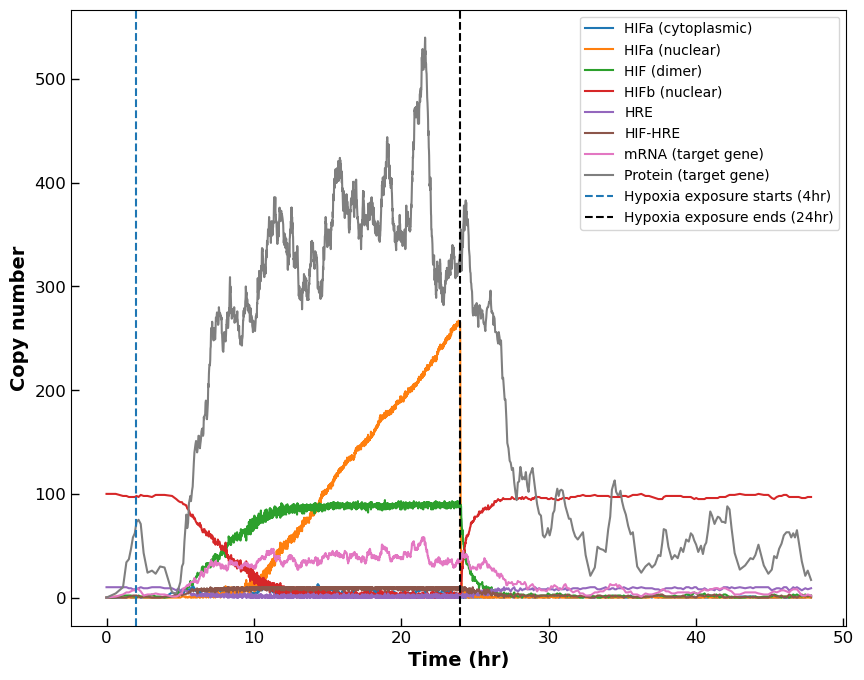

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y[:, 0], label="HIFa (cytoplasmic)")
ax.plot(t, y[:, 1], label="HIFa (nuclear)")
ax.plot(t, y[:, 2], label="HIF (dimer)")
ax.plot(t, y[:, 3], label="HIFb (nuclear)")
ax.plot(t, y[:, 4], label="HRE")
ax.plot(t, y[:, 5], label="HIF-HRE")
ax.plot(t, y[:, 6], label="mRNA (target gene)")
ax.plot(t, y[:, 7], label="Protein (target gene)")
plt.axvline(x=2, linestyle='--', label='Hypoxia exposure starts (4hr)')
plt.axvline(x=24, color="black", linestyle='--', label='Hypoxia exposure ends (24hr)')
ax.tick_params(axis='both', which='both', labelsize=12, direction='in', length=6, width=1)
font_dict = {'weight': 'bold', 'size': 14}
ax.set_xlabel("Time (hr)", fontdict=font_dict)
ax.set_ylabel("Copy number", fontdict=font_dict)
plt.legend()
plt.savefig("Gillespie - everything.png")

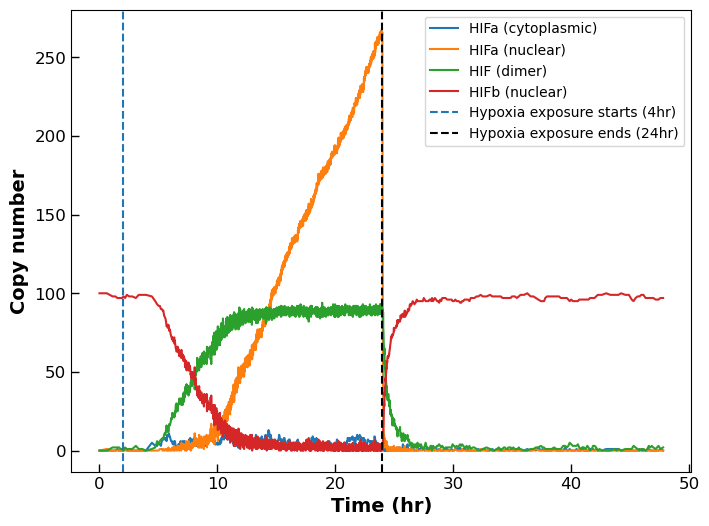

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, y[:, 0], label="HIFa (cytoplasmic)")
ax.plot(t, y[:, 1], label="HIFa (nuclear)")
ax.plot(t, y[:, 2], label="HIF (dimer)")
ax.plot(t, y[:, 3], label="HIFb (nuclear)")
plt.axvline(x=2, linestyle='--', label='Hypoxia exposure starts (4hr)')
plt.axvline(x=24, color="black", linestyle='--', label='Hypoxia exposure ends (24hr)')
ax.tick_params(axis='both', which='both', labelsize=12, direction='in', length=6, width=1)
font_dict = {'weight': 'bold', 'size': 14}
ax.set_xlabel("Time (hr)", fontdict=font_dict)
ax.set_ylabel("Copy number", fontdict=font_dict)
plt.legend()
plt.savefig("Gillespie - HIF production and dimerization.png")

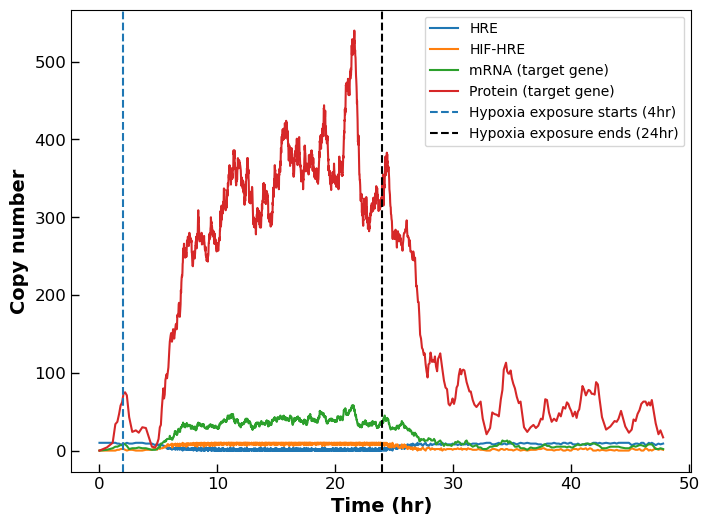

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, y[:, 4], label="HRE")
ax.plot(t, y[:, 5], label="HIF-HRE")
ax.plot(t, y[:, 6], label="mRNA (target gene)")
ax.plot(t, y[:, 7], label="Protein (target gene)")
plt.axvline(x=2, linestyle='--', label='Hypoxia exposure starts (4hr)')
plt.axvline(x=24, color="black", linestyle='--', label='Hypoxia exposure ends (24hr)')
ax.tick_params(axis='both', which='both', labelsize=12, direction='in', length=6, width=1)
font_dict = {'weight': 'bold', 'size': 14}
ax.set_xlabel("Time (hr)", fontdict=font_dict)
ax.set_ylabel("Copy number", fontdict=font_dict)
plt.legend()
plt.savefig("Gillespie - HIF activity")